# About This Notebook

# Testing efficiency of GpyTorch

**In this notebook we will test computational efficiency of GPyTorch by varying the following parameters: number of pool points and dimensionality of the input points. There will be several experiments.**

In [1]:
from matplotlib import image
from matplotlib.pyplot import imread
from IPython import display

import os
import time
import math
from copy import deepcopy
from tqdm import tqdm_notebook

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from scipy.optimize import rosen

# Visualization
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import plotly
import plotly.graph_objs as go

# To plot in offline 
plotly.offline.init_notebook_mode(connected=True)


# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable


import gpytorch
torch.random.manual_seed(123456)

# Required Functions for model and training

In [2]:
class GPyTorch_Framework():
    
    def __init__(self, X_train, y_train):
        
        self.X_train = X_train
        self.y_train = y_train
        
        self.likelihood = gpytorch.likelihoods.GaussianLikelihood()
        self.gp_model = GPRegressionModel(self.X_train, self.y_train, self.likelihood)
        
        
    def train(self, optimizer, mll_loss, num_iters, print_iter = True):
        
        self.gp_model.train()
        self.likelihood.train()
        
        start_time = time.time()
        
        for i in range(num_iters):

            optimizer.zero_grad()
            output = self.gp_model(self.X_train)
            loss = -mll_loss(output, self.y_train)
            loss.backward()
            optimizer.step()    
            
            # Then we print the results for this epoch:
            if print_iter:
                print('Iter %d/%d -MLL Loss: %.3f' % (i + 1, num_iters, loss.item()))
        
        # TODO 
        # It is not a good idea to safe time in that way, because 
        # we will have irrelevant time when will decide to fine-train model for several epochs
        self.training_time = time.time() - start_time
        
    
    def predict_simple(self, X_pool):
       
        # Set into eval mode
        self.gp_model.eval()
        self.likelihood.eval()

        with torch.no_grad():
            start_time = time.time()
            preds = self.gp_model(X_pool)
            exact_covar = preds.covariance_matrix
            exact_covar_time = time.time() - start_time
            
        return preds, exact_covar, exact_covar_time
    
    
    def predict_fast(self, X_pool, max_root_size):
       
        #TODO
        # We need to find out the difference between
        # fast prediction with and without cashe
        
        # Set into eval mode
        self.gp_model.eval()
        self.likelihood.eval()

        with torch.no_grad(), gpytorch.settings.fast_pred_var(), \
                                        gpytorch.settings.max_root_decomposition_size(max_root_size):
            
            start_time = time.time()
            preds = self.gp_model(X_pool)
            fast_covar = preds.covariance_matrix
            fast_covar_time = time.time() - start_time
            
        return preds, fast_covar, fast_covar_time

In [3]:
def calculate_metrics_of_similarity(exact_covar, fast_covar):
    
    mae = (exact_covar - fast_covar).abs().mean()
    sq_norm = (exact_covar - fast_covar).norm()
    
    return mae, sq_norm

In [4]:
class GPRegressionModel(gpytorch.models.ExactGP):
        def __init__(self, X_train, y_train, likelihood):
            super(GPRegressionModel, self).__init__(X_train, y_train, likelihood)
            self.mean_module = gpytorch.means.ConstantMean()
            self.covar_module = gpytorch.kernels.ScaleKernel(
                gpytorch.kernels.RBFKernel()
            )
            
        def forward(self, x):
            mean_x = self.mean_module(x)
            covar_x = self.covar_module(x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [5]:
def generate_Rosenbrock_Problem(num_points, num_dims):
    
    X = np.random.random((num_points, num_dims))
    y = rosen(X.T)
    
    return (torch.Tensor(X), torch.Tensor(y))

# Experiment 1:

**In this experiment we fixed the number of training points to be 1000. And then varied the number of pool points and dimensionality of the input.**

In [6]:
dimensions_ar = np.arange(5, 70, 10, dtype=np.int64)
dimensions_ar

array([ 5, 15, 25, 35, 45, 55, 65])

In [7]:
num_train_points = 1000
num_pool_points_ar = [100, 500, 1000, 2000, 5000]
num_pool_points_ar

[100, 500, 1000, 2000, 5000]

In [8]:
# For debug
# num_train_points = 1000
# dimensions_ar = [4, 6, 8]
# num_pool_points_ar = [20, 30, 40]

In [9]:
num_iters = 5

time_simple_results = {}

for num_dims in tqdm_notebook(dimensions_ar):

    cur_time_simple = []

    X_train, y_train = generate_Rosenbrock_Problem(num_train_points, num_dims)
    
    gpy_torch_framework = GPyTorch_Framework(X_train, y_train)
    
    optimizer = torch.optim.Adam([{'params': gpy_torch_framework.gp_model.parameters()}], lr=0.1)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(gpy_torch_framework.likelihood, 
                                                               gpy_torch_framework.gp_model)
        
    gpy_torch_framework.train(optimizer, mll, num_iters, print_iter = False)
    
    
    for num_points in tqdm_notebook(num_pool_points_ar):
        
        X_pool, y_pool = generate_Rosenbrock_Problem(num_points, num_dims)
        
        simple_predictions, simple_covar_matrix, simple_pred_time = gpy_torch_framework.predict_simple(X_pool)

        cur_time_simple.append(simple_pred_time)

    time_simple_results[num_dims] = cur_time_simple


In [10]:
np.save("time_simple_results", time_simple_results)

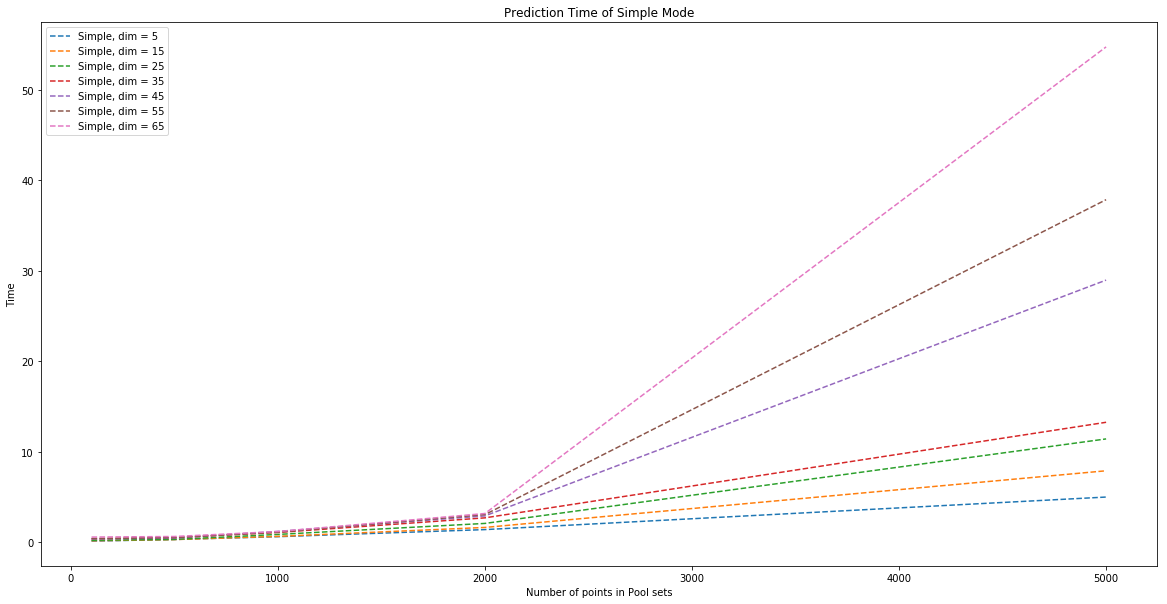

In [15]:
fig = plt.figure(figsize=(20, 10))
    
ax1 = fig.add_subplot(111)
ax1.set_title("Prediction Time of Simple Mode")
ax1.set_xlabel("Number of points in Pool sets")
ax1.set_ylabel("Time")


for num_dims in dimensions_ar:
    ax1.plot(num_pool_points_ar, time_simple_results[num_dims], ls = '--', label = "Simple, dim = {}".format(num_dims))

plt.legend()
plt.show()

In [14]:
time_simple_results[55][4], time_simple_results[55][0] * 4

(37.84406661987305, 1.6351394653320312)